# Variational Autoencoders (VAEs) Neural Network

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Conv2D 
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from keras import backend as K

In [3]:
class Load_dataset():
    
    def __init__(self, path):
        self.path = path
        
        
        # Load Json file
        self.df = self.read_df(self.path)
        # Load data
        self.X, self.Y = self.prepare_data(self.df)

        print("X shape is:{}".format(self.X.shape))
        print("Y shape is:{}".format(self.Y.shape))
        
        # Load X and Y train and test
        self.X_train, self.X_test, self.Y_train, self.Y_test = self.splitting_data()
        print("X_train shape = {}".format(self.X_train.shape))
        print("X_test shape = {}".format(self.X_test.shape))
        print("Y_train shape = {}".format(self.Y_train.shape))
        print("Y_test shape = {}".format(self.Y_test.shape))
        
    def read_df(self, path):
        self.df = pd.read_json(self.path)
        
        # Replace the 'na' with numpy.nan
        self.df.inc_angle.replace({'na':np.nan}, inplace=True)

        # Drop the rows that has NaN value for inc_angle
        self.df.drop(self.df[self.df['inc_angle'].isnull()].index,inplace=True)
        return self.df
        
    def prepare_data(self, df):
        X_band_1 = []
        X_band_2 = []
    
        for band in self.df["band_1"]:
            #Convert to float32
            band_1 = np.array(band).astype(np.float32)
            #Reshaping band_1 and band_2
            band_1 = band_1.reshape(75,75)
            X_band_1.append(band_1)
        
        for band in self.df["band_2"]:
            #Convert to float32
            band_2 = np.array(band).astype(np.float32)
            #Reshaping band_1 and band_2
            band_2 = band_2.reshape(75,75)
            X_band_2.append(band_2)
        
        #Convert list to numpy array
        X_band_1 = np.array(X_band_1)
        X_band_2 = np.array(X_band_2)
    
        # Rescale
        X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
        X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
        #Concatenate band_1 and band_2 to create X for training (or test)
        X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                            X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                            axis=-1)
    
        Y = np.array(self.df["is_iceberg"])
    
        return X, Y
    
    def splitting_data(self):
        #Split data to test and train
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        # Normalize and reshape
        X_train = X_train.astype("float32")
        X_test = X_test.astype("float32")
        X_train = X_train / 255
        X_test = X_test / 255
        
        return X_train, X_test, Y_train, Y_test
    
    # Visualizing some images
    def plot_images(self):
        plt.figure(1)
        plt.subplot(221)
        plt.imshow(self.X_train[5][:,:,0])

        plt.subplot(222)
        plt.imshow(self.X_train[50][:,:,0])

        plt.subplot(223) 
        plt.imshow(self.X_train[500][:,:,0])

        plt.subplot(224)
        plt.imshow(self.X_train[555][:,:,0])
        plt.show()
    

In [4]:
# Define Encoder block
def define_encoder(input_shape, latent_dim):
    # Encoder block
    img_in = Input(shape = input_shape)
    e1 = Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=1)(img_in)
    e1 = Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=1)(e1)
    e1 = BatchNormalization()(e1)
    e1 = LeakyReLU()(e1)
    e1 = MaxPooling2D((2, 2), padding='same')(e1)
    e1 = Dropout(0.3)(e1)
        
    e2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(e1)
    e2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(e2)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU()(e2)
    e2 = MaxPooling2D((2, 2), padding='same')(e2)
    e2 = Dropout(0.3)(e2)
        
    e3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1)(e2)
    e3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1)(e3)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU()(e3)
    e3 = MaxPooling2D((2, 2), padding='same')(e3)
    e3 = Dropout(0.3)(e3)

    e4 = Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=1)(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU()(e4)
    e4 = MaxPooling2D((2, 2), padding='same')(e4)
        
    conv_shape = K.int_shape(e4)[1:]
    # Flatten layer
    flatten = Flatten()(e4)
        
    # Here, two outputs need for latent mean and log variance (mu and std. dev.)
    # Mean values of encoded input
    encoder_mu = Dense(units = latent_dim, name="encoder_mu")(flatten)
    # Variance values of encoded input
    encoder_log_variance = Dense(units = latent_dim, name="encoder_log_variance")(flatten)
        
        
    # Now, in order to gradient descent estimate accurately,
    # we reparameterize sample based on the process defined by Gunderson and Huang:
    # including the shape: mean + sigma squard * eps
    def sampling(mu_log_variance):
        mu, log_variance = mu_log_variance
        # epsilon is epsilon being normal distribution
        epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
        random_sample = mu + K.exp(log_variance/2) * epsilon
        return random_sample
        
    # Sample vector from the latent distribution
    # This the last layer of encoder
    encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])
        
    # Output layer
    encoder = Model(img_in, encoder_output, name="encoder_model")
    encoder.summary()
        
    return encoder, conv_shape, encoder_mu, encoder_log_variance

In [5]:
# Define decoder block
def define_decoder(latent_dim, conv_shape):
    # The shape of decoder is the Z layer's shape
    decoder_input = Input(shape=(latent_dim, ), name="decoder_input")
        
    # Here, the shape of final output should be equal the shape of original input
    # therefore, we need to add Dense layer
    d = Dense(units=np.prod(conv_shape))(decoder_input)
    d_reshape = Reshape(target_shape = conv_shape)(d)
       
    # Upscaling part
    # To convert the last layer in encoder
    d1 = Conv2D(128, (3, 3), padding='same',kernel_initializer='random_uniform')(d_reshape)
    d1 = LeakyReLU()(d1)
    d1 = Dropout(0.3)(d1)
    d1 = UpSampling2D((2, 2))(d1)

    d2 = Conv2D(64, (3, 3), padding='same',kernel_initializer='random_uniform')(d1)
    d2 = Conv2D(64, (3, 3),padding='same',kernel_initializer='random_uniform')(d2)
    d2 = LeakyReLU()(d2)
    d2 = Dropout(0.3)(d2)
    d2 = UpSampling2D((2, 2))(d2)

    d3 = Conv2D(32, (3, 3), padding='same',kernel_initializer='random_uniform')(d2)
    d3 = Conv2D(32, (3, 3), padding='same',kernel_initializer='random_uniform')(d3)
    d3 = LeakyReLU()(d3)
    d3 = Dropout(0.3)(d3)
    d3 = UpSampling2D((2, 2))(d3)

    d4 = Conv2D(16, (3, 3), padding='same',kernel_initializer='random_uniform')(d3)
    d4 = Conv2D(16, (3, 3))(d4)
    d4 = LeakyReLU()(d4)
    d4 = UpSampling2D((2, 2))(d4)
        
    # Output layer
    decoder_output = Conv2D(3, (2, 2), activation="sigmoid", padding="valid")(d4)
        
    decoder = Model(decoder_input, decoder_output)
    decoder.summary()
  
    return decoder
     

In [6]:
# Build VAE model
def VAE_model(input_shape):
    vae_input = Input(shape = input_shape)
    vae_encoder = encoder(vae_input)
    vae_decoder = decoder(vae_encoder)
        
    # Build VAE model
    vae = Model(vae_input, vae_decoder, name="VAE")
    vae.summary()
        
    return vae

In [7]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

X shape is:(1471, 75, 75, 3)
Y shape is:(1471,)
X_train shape = (1176, 75, 75, 3)
X_test shape = (295, 75, 75, 3)
Y_train shape = (1176,)
Y_test shape = (295,)


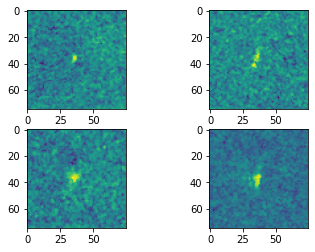

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_277 (Conv2D)             (None, 75, 75, 16)   448         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_278 (Conv2D)             (None, 75, 75, 16)   2320        conv2d_277[0][0]                 
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 75, 75, 16)   64          conv2d_278[0][0]                 
______________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1176/1176 [==============================] - 70s 58ms/sample - loss: 0.9154 - accuracy: 0.5049 - val_loss: 9.3614e-05 - val_accuracy: 0.4153
Epoch 2/5
1176/1176 [==============================] - 66s 56ms/sample - loss: 5.1111e-05 - accuracy: 0.5039 - val_loss: 6.5426e-05 - val_accuracy: 0.4196
Epoch 3/5
1176/1176 [==============================] - 68s 57ms/sample - loss: 5.1079e-05 - accuracy: 0.5046 - val_loss: 6.4131e-05 - val_accuracy: 0.4215
Epoch 4/5
1176/1176 [==============================] - 66s 56ms/sample - loss: 5.1079e-05 - accuracy: 0.5043 - val_loss: 6.9144e-05 - val_accuracy: 0.4308
Epoch 5/5
1176/1176 [==============================] - 66s 56ms/sample - loss: 5.1079e-05 - accuracy: 0.5045 - val_loss: 6.2746e-05 - val_accuracy: 0.4274


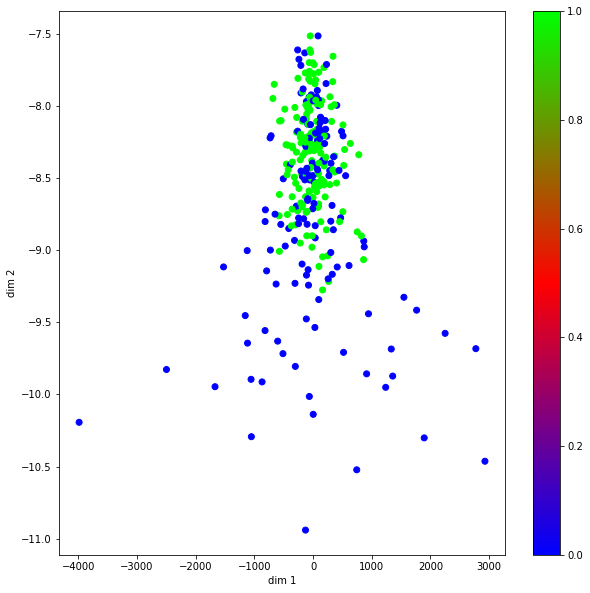

In [74]:
if __name__ == '__main__':
    latent_dim = 2
    IMG_WIDTH = 75
    IMG_HEIGHT = 75
    NUM_CHANNELS = 3
    input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
        
    # Load dataset
    path = "/content/drive/MyDrive/train.json"
    LoadData = Load_dataset(path)
        
    # Load train and test data
    X_train, X_test, Y_train, Y_test = LoadData.splitting_data() 
    
    # Plotting some images
    LoadData.plot_images()
    
    # Build Encoder block
    encoder, conv_shape, encoder_mu, encoder_log_variance = define_encoder(input_shape, latent_dim)
    
    # Build decoder block
    decoder = define_decoder(latent_dim, conv_shape)
    
    # Build VAE model
    vae = VAE_model(input_shape)
    
    # Calculate vae loss
    vae_loss = loss_func(encoder_mu, encoder_log_variance)
    
    # Compile the model
    vae.compile(optimizer=Adam(lr=0.0005), loss = vae_loss, metrics=["accuracy"])
    
    # Fit the model
    # the number of input data is a multiple of your batch size, then there is no such error
    vae.fit(X_train, X_train, epochs = 5, batch_size=1, shuffle=True, validation_data=(X_test, X_test))
    
    # Predict the model
    encoded_images = encoder.predict(X_test)
    encoded_images = np.array(encoded_images)
    #print("The shape of encoded_images is : {}".format(encoded_images.shape))
    
    decoded_images = decoder.predict(encoded_images)
    decoded_images = np.array(decoded_images)
    #print("The shape of decoded_images is : {}".format(decoded_images.shape))
    
    #decoded_images_orig = np.reshape(decoded_images[:,:,:,0], newshape=(decoded_images.shape[0], 75, 75))
    #print("The shape of decoded_images_orig is : {}".format(decoded_images_orig.shape))

    #Plot dim1 and dim2 for encoded_images
    plt.figure(figsize=(10, 10))
    plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=Y_test, cmap='brg')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.colorbar()
    plt.show()
    